In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Download historical data for AAPL
ticker = 'AAPL'
train = yf.download(ticker, start='2015-01-01', end='2021-12-31', interval='1wk', auto_adjust=False)
train['Returns'] = train['Adj Close'].pct_change()
train.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [3]:
from sklearn.model_selection import ParameterGrid

# Define parameter grid
param_grid = {
    'window': [5,10], 
    'upper_percentage': np.arange(0.05, 0.31, 0.01), 
    'lower_percentage': np.arange(0.05, 0.31, 0.01), 
}

transaction_cost = 0.001  # 0.1% transaction cost

# Evaluate performance for each combination
# takes ~30 minutes in grid search
results = []
for params in ParameterGrid(param_grid):
    data = train.copy()
    # Calculate the middle band (SMA)
    data['Middle Band'] = data['Adj Close'].rolling(window=params['window']).mean()

    # Calculate the upper and lower bands
    data['Upper Band'] = data['Middle Band'] * (1 + params['upper_percentage'])
    data['Lower Band'] = data['Middle Band'] * (1 - params['lower_percentage'])

    # Drop rows with missing values (due to rolling window)
    data.dropna(inplace=True)

    # Initialize signal columns
    data['Signal'] = 0
    data['Above Upper'] = False  # Track if price has risen above the upper band
    data['Below Lower'] = False  # Track if price has fallen below the lower band

    # Generate signals
    for i in range(1, len(data)):
        # Access scalar values for comparison
        adj_close = data['Adj Close'].iloc[i].values[0]
        upper_band = data['Upper Band'].iloc[i]
        lower_band = data['Lower Band'].iloc[i]

        # Check if price has risen above the upper band
        if adj_close > upper_band:
            data.loc[data.index[i], 'Above Upper'] = True

        # Check if price has fallen below the lower band
        if adj_close < lower_band:
            data.loc[data.index[i], 'Below Lower'] = True

        # Sell signal: Price rises above upper band and then drops back to upper band
        if data['Above Upper'].iloc[i - 1] and adj_close <= upper_band:
            data.loc[data.index[i], 'Signal'] = -1
            data.loc[data.index[i], 'Above Upper'] = False  # Reset the flag

        # Buy signal: Price falls below lower band and then rises back to lower band
        if data['Below Lower'].iloc[i - 1] and adj_close >= lower_band:
            data.loc[data.index[i], 'Signal'] = 1
            data.loc[data.index[i], 'Below Lower'] = False  # Reset the flag

    # Forward fill the signals to hold the position until the next signal
    data['Position'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)

    # Calculate strategy returns
    data['Strategy Returns'] = data['Position'].shift(1) * data['Returns']

    # Initialize transaction costs
    data['Transaction Cost'] = 0

    # Calculate transaction costs for each trade
    for i in range(1, len(data)):
        if data['Signal'].iloc[i] != data['Signal'].iloc[i - 1]:  # Trade occurred
            trade_value = abs(data['Adj Close'].iloc[i] * data['Position'].iloc[i])  # Absolute value of the trade
            data.loc[data.index[i], 'Transaction Cost'] = trade_value * transaction_cost

    # Calculate net strategy returns (after transaction costs)
    data['Net Strategy Returns'] = data['Strategy Returns'] - data['Transaction Cost']

    # Calculate cumulative net returns
    cumulative_net_returns = (1 + data['Net Strategy Returns']).cumprod().iloc[-1]

    # Store results
    results.append((params['window'], params['upper_percentage'],
                    params['lower_percentage'], cumulative_net_returns))


Best Parameters:
Window                5.000000
Upper Percentage      0.120000
Lower Percentage      0.090000
Cumulative Returns    8.929675
Name: 222, dtype: float64


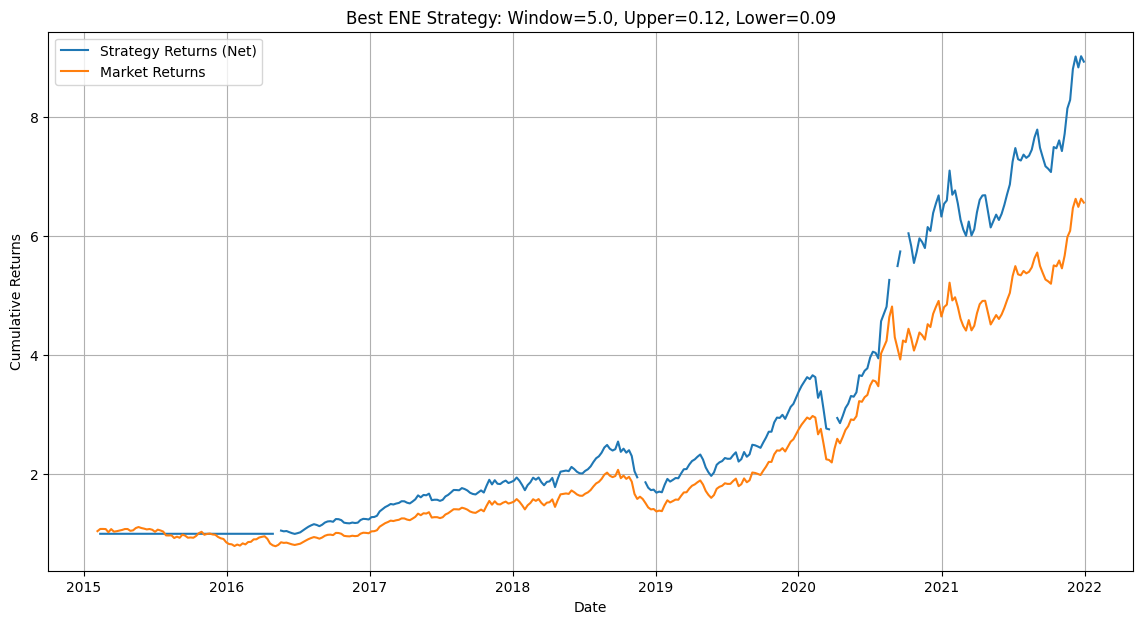

In [4]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Window', 'Upper Percentage', 'Lower Percentage', 'Cumulative Returns'])

# Find the best parameters
best_params = results_df.loc[results_df['Cumulative Returns'].idxmax()]
print("Best Parameters:")
print(best_params)

# Re-run the strategy with the best parameters
best_window = best_params['Window']
best_upper_percentage = best_params['Upper Percentage']
best_lower_percentage = best_params['Lower Percentage']

def rerun_strategy(data): 
    # Re-run the strategy with the best parameters
    data['Middle Band'] = data['Adj Close'].rolling(window=int(best_window)).mean()
    data['Upper Band'] = data['Middle Band'] * (1 + best_upper_percentage)
    data['Lower Band'] = data['Middle Band'] * (1 - best_lower_percentage)
    
    # Drop rows with missing values (due to rolling window)
    data.dropna(inplace=True)
    
    # Initialize signal columns
    data['Signal'] = 0
    data['Above Upper'] = False  # Track if price has risen above the upper band
    data['Below Lower'] = False  # Track if price has fallen below the lower band
    
    # Generate signals
    for i in range(1, len(data)):
        # Access scalar values for comparison
        adj_close = data['Adj Close'].iloc[i].values[0]
        upper_band = data['Upper Band'].iloc[i]
        lower_band = data['Lower Band'].iloc[i]
    
        # Check if price has risen above the upper band
        if adj_close > upper_band:
            data.loc[data.index[i], 'Above Upper'] = True
    
        # Check if price has fallen below the lower band
        if adj_close < lower_band:
            data.loc[data.index[i], 'Below Lower'] = True
    
        # Sell signal: Price rises above upper band and then drops back to upper band
        if data['Above Upper'].iloc[i - 1] and adj_close <= upper_band:
            data.loc[data.index[i], 'Signal'] = -1
            data.loc[data.index[i], 'Above Upper'] = False  # Reset the flag
    
        # Buy signal: Price falls below lower band and then rises back to lower band
        if data['Below Lower'].iloc[i - 1] and adj_close >= lower_band:
            data.loc[data.index[i], 'Signal'] = 1
            data.loc[data.index[i], 'Below Lower'] = False  # Reset the flag
    
    # Forward fill the signals to hold the position until the next signal
    data['Position'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)
    
    # Calculate strategy returns
    data['Strategy Returns'] = data['Position'].shift(1) * data['Returns']
    
    # Initialize transaction costs
    data['Transaction Cost'] = 0
    
    # Calculate transaction costs for each trade
    for i in range(1, len(data)):
        if data['Signal'].iloc[i] != data['Signal'].iloc[i - 1]:  # Trade occurred
            trade_value = abs(data['Adj Close'].iloc[i] * data['Position'].iloc[i])  # Absolute value of the trade
            data.loc[data.index[i], 'Transaction Cost'] = trade_value * transaction_cost
    
    # Calculate net strategy returns (after transaction costs)
    data['Net Strategy Returns'] = data['Strategy Returns'] - data['Transaction Cost']
    
    # Calculate cumulative net returns
    data['Cumulative Net Returns'] = (1 + data['Net Strategy Returns']).cumprod()
    return data

train_returns = rerun_strategy(train)

#  Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_returns['Cumulative Net Returns'], label='Strategy Returns (Net)')
plt.plot((1 + train_returns['Returns']).cumprod(), label='Market Returns')
plt.title(f'Best ENE Strategy: Window={best_window}, Upper={best_upper_percentage:.2f}, Lower={best_lower_percentage:.2f}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

[*********************100%***********************]  1 of 1 completed


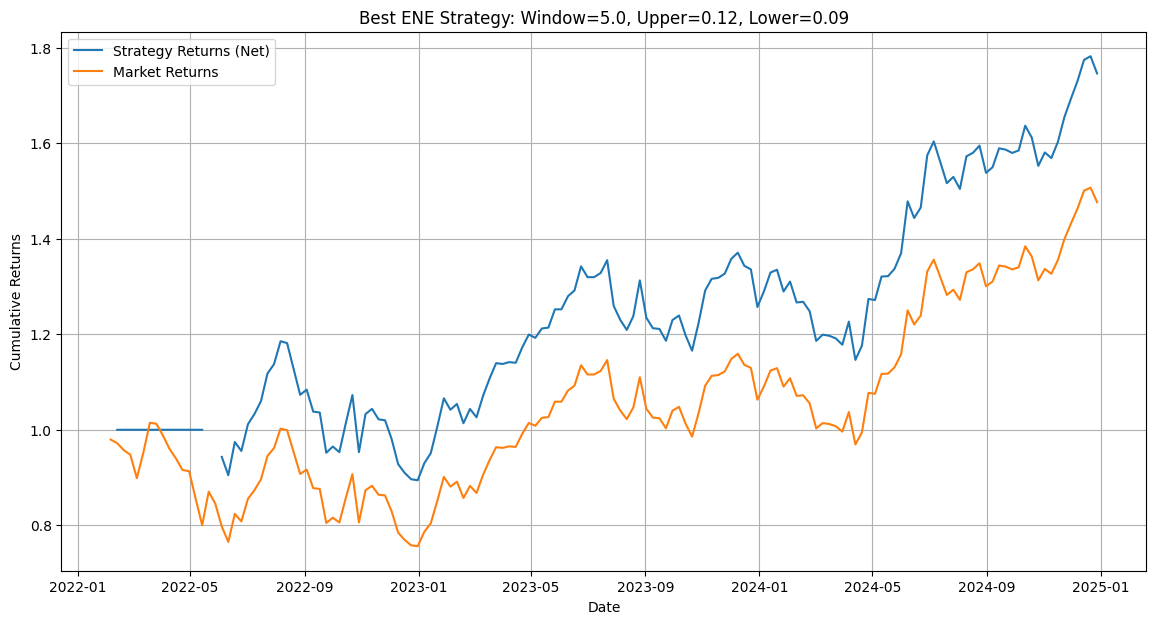

In [5]:
test = yf.download(ticker, start='2022-01-01', end='2024-12-31', interval='1wk', auto_adjust=False)
test['Returns'] = test['Adj Close'].pct_change()
test.dropna(inplace=True)

test_returns = rerun_strategy(test)

#  Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_returns['Cumulative Net Returns'], label='Strategy Returns (Net)')
plt.plot((1 + test_returns['Returns']).cumprod(), label='Market Returns')
plt.title(f'Best ENE Strategy: Window={best_window}, Upper={best_upper_percentage:.2f}, Lower={best_lower_percentage:.2f}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()